# Machine Learning on Drug Recommendation

## Setting Up The Environment

Importing packages

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns 
import re 
from wordcloud import WordCloud

import nltk # natural language tool kit 
nltk.download('punkt')

from sklearn.model_selection import train_test_split

from nltk.corpus import stopwords
from nltk import word_tokenize
from collections import Counter

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

[nltk_data] Downloading package punkt to /home/vscode/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Extraction of Data

In [2]:
train = pd.read_csv('/workspaces/Secure-Pharmacist/Python_Model/Datasets/drugsComTrain_raw.csv', index_col=False).drop(["date", "usefulCount"], axis=1)
train.head()

,uniqueID,drugName,condition,review,rating
0,67267,Omeprazole,Zollinger-Ellison Syndrome,I have a hiatal hernia which can cause bad ref...,10.0
1,182560,Mirena,Birth Control,I have had my IUD for over a year now and I th...,10.0
2,131116,Levonorgestrel,Birth Control,I have had my IUD for over a year now and I th...,10.0
3,119151,Zoloft,Depression,Ive been on Zoloft 50mg for over two years. I ...,9.0
4,139141,Phentermine,Weight Loss,I have used this pill off and on for the past ...,10.0


In [4]:
test = pd.read_csv('/workspaces/Secure-Pharmacist/Python_Model/Datasets/drugsComTest_raw.csv', index_col=False).drop(["date", "usefulCount"], axis=1)
test.head()

,uniqueID,drugName,condition,review,rating
0,96615,Sertraline,Depression,Ive been on Zoloft 50mg for over two years. I ...,9.0
1,228099,Etonogestrel,Birth Control,I was very nervous about trying Implanon after...,10.0
2,189774,Oxycodone,Pain,Ahhhh the dreaded drug...no matter what you ca...,9.0
3,151366,OxyContin,Pain,Ahhhh the dreaded drug...no matter what you ca...,9.0
4,96501,Sertraline,Depression,I am 55 years old and have been taking Zoloft ...,10.0


## Cleaning Of Datasets

### Checking for Null Values and Replacing if any

Train Dataset

In [5]:
print('Before dropping:\n', train.isna().sum())
train = train.dropna()
print('After dropping:\n', train.isna().sum())

Before dropping:
 uniqueID      0
drugName      0
condition    23
review        0
rating        1
dtype: int64
After dropping:
 uniqueID     0
drugName     0
condition    0
review       0
rating       0
dtype: int64


Test Dataset

In [6]:
print('Before dropping:\n', test.isna().sum())
test = test.dropna()
print('After dropping:\n', test.isna().sum())

Before dropping:
 uniqueID      0
drugName      0
condition    71
review        0
rating        1
dtype: int64
After dropping:
 uniqueID     0
drugName     0
condition    0
review       0
rating       0
dtype: int64


### Cleaning the Review Column

In [7]:
def clean_text(Review):
    Review = str(Review).lower() # convert to lowercase
    Review = re.sub('\[.*?\]', '', Review)
    Review = re.sub('https?://\S+|www\.\S+', '', Review) # Remove URls
    Review = re.sub('<.*?>+', '', Review)
    Review = re.sub(r'[^a-z0-9\s]', '', Review) # Remove punctuation
    Review = re.sub('\n', '', Review)
    Review = re.sub('\w*\d\w*', '', Review)
    return Review

stop_words = set(stopwords.words('english'))
stopword = []

def remove_stopword(stop_words, sentence):
    return [word for word in nltk.word_tokenize(sentence) if word not in stop_words]

Train Dataset

In [8]:
train['review'] = train['review'].apply(clean_text)
print(train['review'])

sentence = train['review'][0]
train['keywords'] = train['review'].apply(lambda row: remove_stopword(stop_words, row))
print(train['keywords'].head())

0        i have a hiatal hernia which can cause bad ref...
1        i have had my iud for over a year now and i th...
2        i have had my iud for over a year now and i th...
3        ive been on zoloft  for over two years i am a ...
4        i have used this pill off and on for the past ...
                               ...                        
16313    i have  disorder with history of psychotic fea...
16314    i have  disorder with history of psychotic fea...
16315    awesome could feel like i had to go but kept p...
16316    this medication opened up a whole new world fo...
16317    i was on this medicine at first  a day then  i...
Name: review, Length: 16295, dtype: object
0    [hiatal, hernia, cause, bad, reflux, etc, ive,...
1    [iud, year, think, best, thing, ever, first, g...
2    [iud, year, think, best, thing, ever, first, g...
3    [ive, zoloft, two, years, relaxed, easygoing, ...
4    [used, pill, past, years, say, best, pill, los...
Name: keywords, dtype: object


Test Dataset

In [9]:
test['review'] = test['review'].apply(clean_text)
print(test['review'])

sentence = test['review'][0]
test['keywords'] = test['review'].apply(lambda row: remove_stopword(stop_words, row))
print(test['keywords'].head())

0        ive been on zoloft  for over two years i am a ...
1        i was very nervous about trying implanon after...
2        ahhhh the dreaded drugno matter what you call ...
3        ahhhh the dreaded drugno matter what you call ...
4        i am  years old and have been taking zoloft ov...
                               ...                        
28099    the medication is a very good antibiotic amp i...
28100    the medication is a very good antibiotic amp i...
28101    i have been on yaz for hormonal acne for about...
28102    hiv viral load of  in june  undetectable in se...
28103    the past three years i used implanon the first...
Name: review, Length: 28033, dtype: object
0    [ive, zoloft, two, years, relaxed, easygoing, ...
1    [nervous, trying, implanon, reading, negative,...
2    [ahhhh, dreaded, drugno, matter, call, whateve...
3    [ahhhh, dreaded, drugno, matter, call, whateve...
4    [years, old, taking, zoloft, years, miracle, m...
Name: keywords, dtype: object


## General Analysis Of Data

Train Dataset

In [10]:
print(train.shape)
print(train.info())

(16295, 6)
<class 'pandas.core.frame.DataFrame'>
Index: 16295 entries, 0 to 16317
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   uniqueID   16295 non-null  int64  
 1   drugName   16295 non-null  object 
 2   condition  16295 non-null  object 
 3   review     16295 non-null  object 
 4   rating     16295 non-null  float64
 5   keywords   16295 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 1.4+ MB
None


Test Dataset

In [11]:
print(train.shape)
print(train.info())

(16295, 6)
<class 'pandas.core.frame.DataFrame'>
Index: 16295 entries, 0 to 16317
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   uniqueID   16295 non-null  int64  
 1   drugName   16295 non-null  object 
 2   condition  16295 non-null  object 
 3   review     16295 non-null  object 
 4   rating     16295 non-null  float64
 5   keywords   16295 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 1.4+ MB
None


## Visualization For Dataset

### Top Conditions based on Drug Availability

Calculating Data

In [12]:
topConditions = train['condition'].value_counts().head(10)
print(topConditions)

condition
Depression             2087
Anxiety                1492
Pain                    760
Weight Loss             563
Bipolar Disorde         529
Obesity                 516
Insomnia                505
High Blood Pressure     503
Anxiety and Stress      484
ADHD                    424
Name: count, dtype: int64


Creation Of Pie Chart

<BarContainer object of 10 artists>

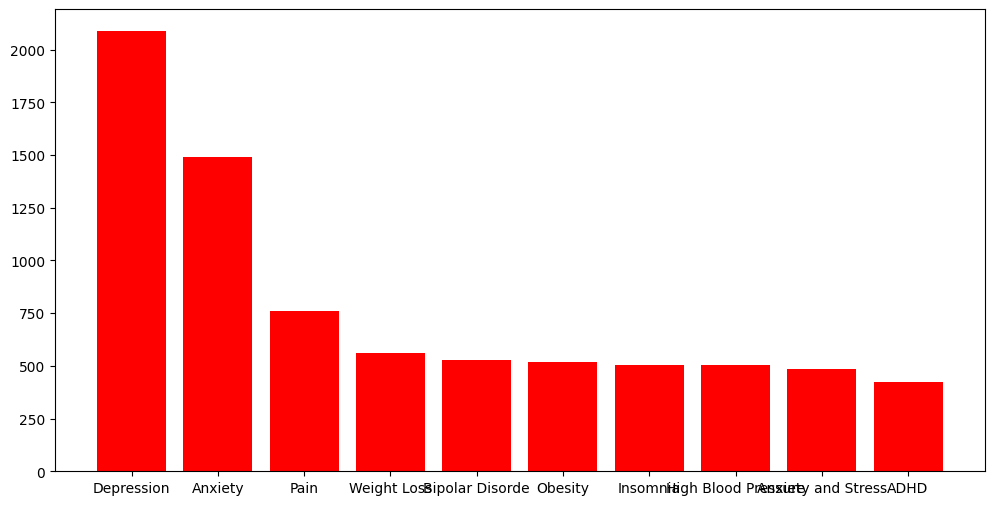

In [13]:
fig, ax = plt.subplots(1,1,figsize=(12,6))
ax.bar(topConditions.index, topConditions.values, width=0.8, color='r')

From the above Graph we can see that most number of medicines is there for Birth Control, next being Depression.

### Significant Textual Data Points

Data Calculation

In [14]:
text = " ".join(str(each) for each in train['keywords'])

Creation Of Bar Chart

/tmp/ipykernel_3332/740237053.py:6: UserWarning: Ignoring specified arguments in this call because figure with num: 1 already exists
  plt.figure(1,figsize=(12, 12))


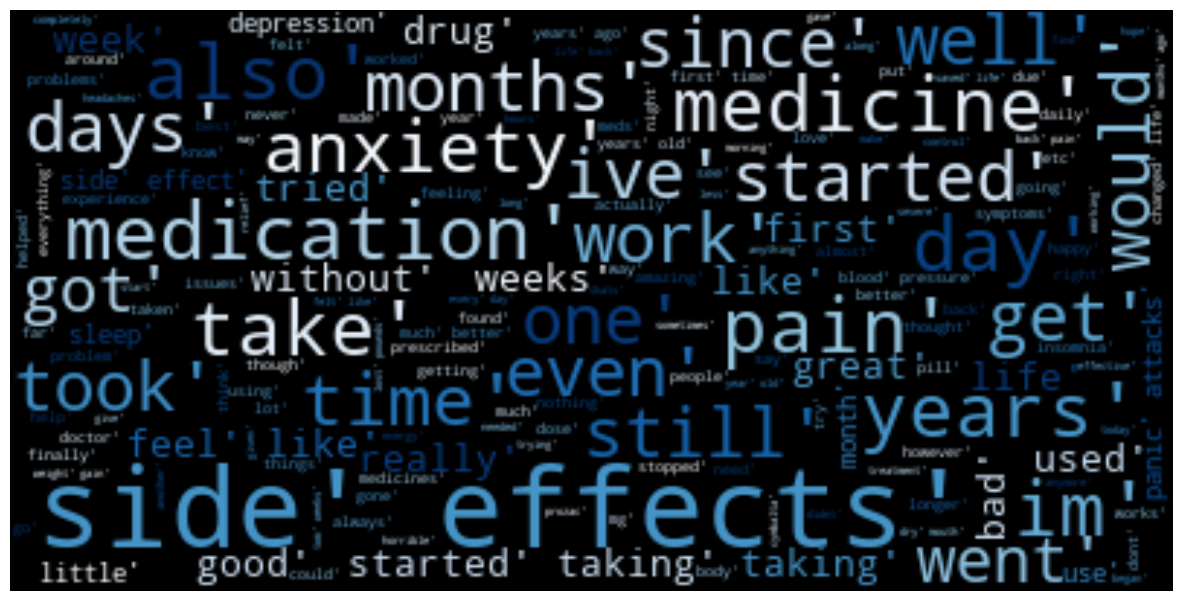

In [15]:
wordcloud = WordCloud(max_words=200,colormap='Blues', background_color="black").generate(text)
plt.figure(figsize=(15,10))

plt.imshow(wordcloud, interpolation='Bilinear')
plt.axis("off")
plt.figure(1,figsize=(12, 12))
plt.show()

Word Cloud is a data visualization technique used for representing text data in which the size of each word indicates its frequency or importance. Significant textual data points have been highlighted in this word cloud.

## Machine Learning Model

Creation of Data Used For Training ML Model

In [16]:
x = train['keywords'].astype(str)
y = train['rating'].astype(str)

X_train, X_test, Y_train, Y_test = train_test_split(x, y, random_state = 42, test_size = 0.20)
X_train.shape,X_test.shape,Y_train.shape

((13036,), (3259,), (13036,))

Creating an object of Pipeline and Fitting Data

In [17]:
pipeline = Pipeline([('vect', CountVectorizer(stop_words= "english", lowercase = True)), 
                     ('tfidf', TfidfTransformer(use_idf = True, smooth_idf = True)),
                     ('clf', MultinomialNB(alpha =1)),])

model = pipeline.fit(X_train,Y_train)

Accuracy Testing

In [18]:
print('Training accuracy:', model.score(X_train, Y_train))
print('Test accuracy:', model.score(X_test, Y_test))

Training accuracy: 0.5136544952439399
Test accuracy: 0.5023013194231359
